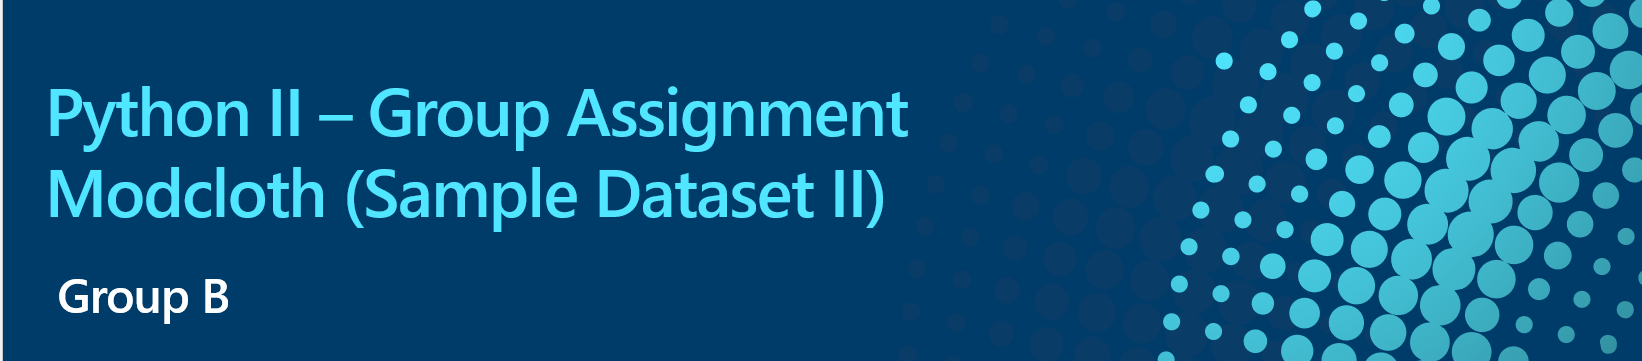

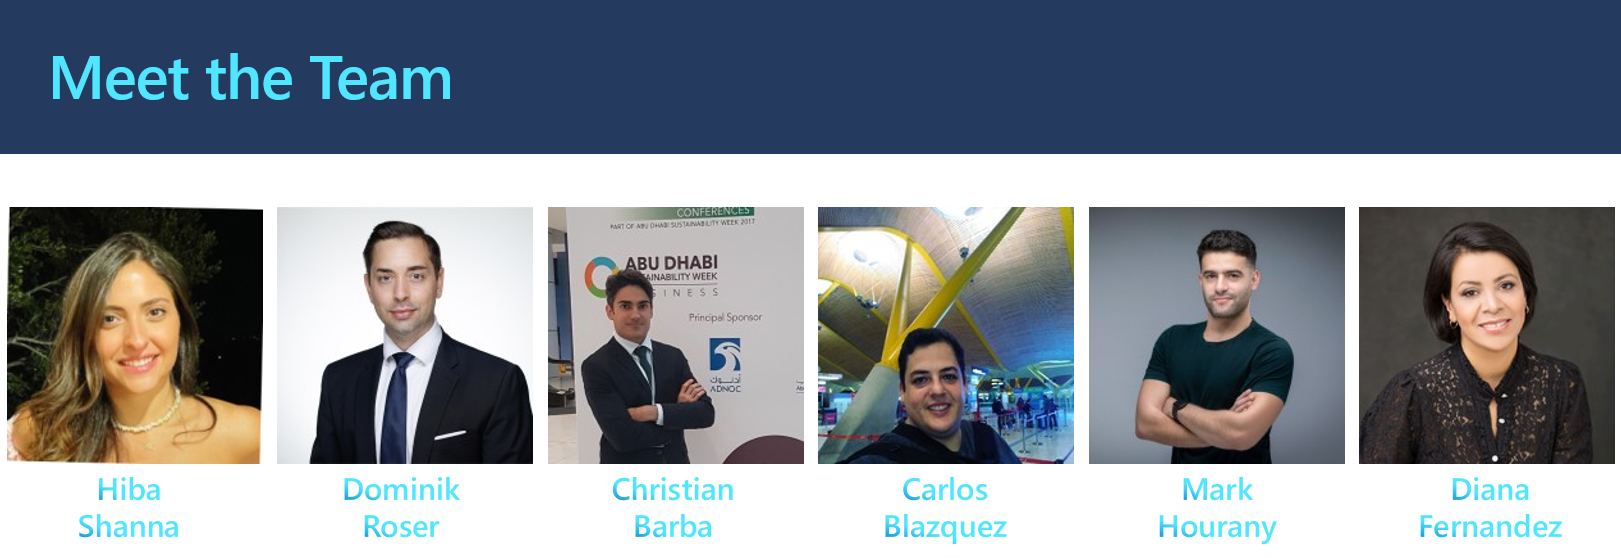


# An approach to detecting and understanding Machine Learning Biases using classes

## Table of Contents

* [Background on Marketing Bias and the Modcloth Database](#0)
* [1. FairDetect Framework](#1)
* [2. Aequitas Framework](#2)


<a id='0'></a>
## Background on Marketing Bias and the  Modcloth Dataset

In the electronic marketplace and online retail, recommender systems **are widely used as decision aids**. It is well know as well that, online recommendations have a big influence on many consumers' decisions. Recent studies indicate that online suggestions can manipulate consumers' preferences ratings and also also their readiness to buy certain merchandise.

Recommendation algorithms, which gather and generalize user preference patterns from recorded consumer-product interactions as pruchaces and raitings, often fall under the category of collaborative filtering. 

These feedback exchanges could present consumers with unfair (or irrelevant) recommendations or underrepresented items in the input data because of various biases that may be at play.

A common hypothesis (known as ‘selfcongruence’) is that a consumer may tend to buy a product because its public impression (in our case a product image), among other alternatives, is consistent with one’s self-perceptions (user identity). Based on this assumption, the selection of human models for a product could influence a consumer’s behavior. Studies indicate that generally, there are more interactions than expected on the consumer-product segments where users’ identities match the product images (‘self-congruity’), while several market segments are underrepresented in the data. For example, (‘Large’ user, ‘Small’ product). (https://dl.acm.org/doi/pdf/10.1145/3336191.3371855)

Under this premise, we will use the Modcloth dataset, to test bias both on **Fairdetect** and **Aequitas** framework. We will look for bias in the creation of a machine learning model to predict if an marketing strategy could affect consumer's behavour resulting in a biased interaction dataset, which is commonly used as the input for modern recommendeer systems.


**ModCloth is an e-commerce website which sells women’s clothing and accessories.*** Many products in ModCloth include two human models with different body shapes and measurements of these models. Users can optionally provide the product sizes they purchased and fit feedback (‘Just Right’, ‘Slightly Larger’, ‘Larger’, ‘Slightly Smaller’ or ‘Smaller’) along with their reviews. 

Therefore our source of bias is the dimension of human body shape. There are 2 variables of interest:

**User identity:** is the perception of oneself; It calculates the average size each user purchased and classify users into ‘Small’ and ‘Large’ groups based on the same standard as the product body shape image.

**Product image:** the public impression of a product; attributes of the human models included in the product pictures are used to generate this data set. Products with only one human model wearing a relatively small size (‘XS’, ‘S’, ‘M’ or ‘L’) are labeled as the ‘Small’ group while products with two models (an additional model wearing a plus-size: 1X’, ‘2X’, ‘3X’ or ‘4X’) are referred as the ‘Small&Large’ group

With the use of **Fairdetect** and **Aequitas** frameworks, we want to understand the existence of the association between product image and user identity in consumers’ product selections.



<a id='1'></a>
## 1. FairDetect Framework

Congregating the various theoretical concepts into a practical framework, we can follow the “theoretical lens of a ‘sense-plan-act’ cycle”, as described by the HLEG framework (European Commission and Directorate-General for Communications Networks, Content and Technology, 2019). Applying this concept to the problem of ML fairness, we can break down three core steps in providing robust, and responsible artificial intelligence: Identify, Understand, and Act (IUA).

1. __Identify__: The process of exposing direct or indirect biases within a dataset and/or model.
1. __Understand__: The process of isolating impactful scenarios and obtaining trans parent explanations for outcomes.
1. __Act__: The process of reporting and rectifying identified disparities within the

By understanding the philosophical forms of unfairness as defined by our review of the literature and categorizing our prominent fairness metrics into the overarching categories of representation, ability, and performance, we can establish a series of tests to “identify” levels of disparities between sensitive groups at different levels. Merging these findings with the explainability of our models through the use of white-box models, or Shapley value estimation for black-box models, we can dig deeper into the model’s predictions, “understanding” how classifications were made, and how they varied from the natural dataset exposing both natural biases as well as added model differences. Finally, by probing further into levels of misclassification, in particular looking at negative outcomes, we can isolate groups most at risk and set up a series of “actions” that can be taken to mitigate the effects. Given this three-step framework which combines societal, legal, and technical considerations, the paper will then go through a series of cases, and examine the proposed framework.

<a id='2'></a>
## Using FairDetect functions to find biases


### Load the functions from fairdetect_functions


In [1]:
# Creating our classes

class bias_detection:
    def __init__(self,model,X_test,y_test):
        self.model,self.X_test,self.y_test= model, X_test, y_test

    def create_labels(self,sensitive):
        sensitive_label = {}
        for i in set(self.X_test[sensitive]):
            text = "Please Enter Label for Group" +" "+ str(i)+": "
            label = input(text)
            sensitive_label[i]=label
        return(sensitive_label)

    def representation(self,X_test,y_test,sensitive,labels,predictions):
        full_table = X_test.copy()
        sens_df = {}

        for i in labels:
            full_table['p'] = predictions
            full_table['t'] = y_test
            sens_df[labels[i]] = full_table[full_table[sensitive]==i]

        contigency_p = pd.crosstab(full_table[sensitive], full_table['t']) 
        cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
        contigency_pct_p = pd.crosstab(full_table[sensitive], full_table['t'], normalize='index')

        sens_rep = {}
        for i in labels:
            sens_rep[labels[i]] = (X_test[sensitive].value_counts()/X_test[sensitive].value_counts().sum())[i]

        labl_rep = {}
        for i in labels:
            labl_rep[str(i)] = (y_test.value_counts()/y_test.value_counts().sum())[i]


        fig = make_subplots(rows=1, cols=2)

        for i in labels:
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [labels[i]],
            y= [sens_rep[labels[i]]]),row=1,col=1)

            fig.add_trace(go.Bar(
            showlegend=False,
            x = [str(i)],
            y= [labl_rep[str(i)]],
            marker_color=['orange','blue'][i]),row=1,col=2)

        c, p, dof, expected = chi2_contingency(contigency_p)
        cont_table = (tabulate(contigency_pct_p.T, headers=labels.values(), tablefmt='fancy_grid'))

        return cont_table, sens_df, fig, p



    def ability(self,sens_df,labels):
        sens_conf = {}
        for i in labels:
            sens_conf[labels[i]] = confusion_matrix(list(sens_df[labels[i]]['t']), list(sens_df[labels[i]]['p']), labels=[0,1]).ravel()

        true_positive_rate = {}
        false_positive_rate = {}
        true_negative_rate = {}
        false_negative_rate = {}

        for i in labels:
            true_positive_rate[labels[i]] = (sens_conf[labels[i]][3]/(sens_conf[labels[i]][3]+sens_conf[labels[i]][2]))
            false_positive_rate[labels[i]] = (sens_conf[labels[i]][1]/(sens_conf[labels[i]][1]+sens_conf[labels[i]][0]))
            true_negative_rate[labels[i]] = 1 - false_positive_rate[labels[i]]
            false_negative_rate[labels[i]] = 1 - true_positive_rate[labels[i]]

        return(true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate)



    def ability_plots(self, labels,TPR,FPR,TNR,FNR):
        fig = make_subplots(rows=2, cols=2, 
                            subplot_titles=("True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate"))

        x_axis = list(labels.values())
        fig.add_trace(
            go.Bar(x = x_axis, y=list(TPR.values())),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FPR.values())),
            row=1, col=2
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(TNR.values())),
            row=2, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FNR.values())),
            row=2, col=2
        )

        fig.update_layout(showlegend=False,height=600, width=800, title_text="Ability Disparities")
        fig.show()

    def ability_metrics(self,TPR,FPR,TNR,FNR):
        TPR_p = chisquare(list(np.array(list(TPR.values()))*100))[1]
        FPR_p = chisquare(list(np.array(list(FPR.values()))*100))[1]
        TNR_p = chisquare(list(np.array(list(TNR.values()))*100))[1]
        FNR_p = chisquare(list(np.array(list(FNR.values()))*100))[1]

        if TPR_p <= 0.01:
            print("*** Reject H0: Significant True Positive Disparity with p=",TPR_p)
        elif TPR_p <= 0.05:
            print("** Reject H0: Significant True Positive Disparity with p=",TPR_p)
        elif TPR_p <= 0.1:
            print("*  Reject H0: Significant True Positive Disparity with p=",TPR_p)
        else:
            print("Accept H0: True Positive Disparity Not Detected. p=",TPR_p)

        if FPR_p <= 0.01:
            print("*** Reject H0: Significant False Positive Disparity with p=",FPR_p)
        elif FPR_p <= 0.05:
            print("** Reject H0: Significant False Positive Disparity with p=",FPR_p)
        elif FPR_p <= 0.1:
            print("*  Reject H0: Significant False Positive Disparity with p=",FPR_p)
        else:
            print("Accept H0: False Positive Disparity Not Detected. p=",FPR_p)

        if TNR_p <= 0.01:
            print("*** Reject H0: Significant True Negative Disparity with p=",TNR_p)
        elif TNR_p <= 0.05:
            print("** Reject H0: Significant True Negative Disparity with p=",TNR_p)
        elif TNR_p <= 0.1:
            print("*  Reject H0: Significant True Negative Disparity with p=",TNR_p)
        else:
            print("Accept H0: True Negative Disparity Not Detected. p=",TNR_p)

        if FNR_p <= 0.01:
            print("*** Reject H0: Significant False Negative Disparity with p=",FNR_p)
        elif FNR_p <= 0.05:
            print("** Reject H0: Significant False Negative Disparity with p=",FNR_p)
        elif FNR_p <= 0.1:
            print("*  Reject H0: Significant False Negative Disparity with p=",FNR_p)
        else:
            print("Accept H0: False Negative Disparity Not Detected. p=",FNR_p)




    def predictive(self,labels,sens_df):
        precision_dic = {}

        for i in labels:
            precision_dic[labels[i]] = precision_score(sens_df[labels[i]]['t'],sens_df[labels[i]]['p'])

        fig = go.Figure([go.Bar(x=list(labels.values()), y=list(precision_dic.values()))])

        pred_p = chisquare(list(np.array(list(precision_dic.values()))*100))[1]

        return(precision_dic,fig,pred_p)




    def identify_bias(self,sensitive,labels):
        predictions = self.model.predict(self.X_test)
        cont_table,sens_df,rep_fig,rep_p = self.representation(self.X_test,self.y_test,sensitive,labels,predictions)

        print("REPRESENTATION")
        rep_fig.show()

        print(cont_table,'\n')

        if rep_p <= 0.01:
            print("*** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        elif rep_p <= 0.05:
            print("** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        elif rep_p <= 0.1:
            print("* Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        else:
            print("Accept H0: No Significant Relation Between",sensitive,"and Target Detected. p=",rep_p)

        TPR, FPR, TNR, FNR = self.ability(sens_df,labels)
        print("\n\nABILITY")
        self.ability_plots(labels,TPR,FPR,TNR,FNR)
        self.ability_metrics(TPR,FPR,TNR,FNR)


        precision_dic, pred_fig, pred_p = self.predictive(labels,sens_df)
        print("\n\nPREDICTIVE")
        pred_fig.show()

        if pred_p <= 0.01:
            print("*** Reject H0: Significant Predictive Disparity with p=",pred_p)
        elif pred_p <= 0.05:
            print("** Reject H0: Significant Predictive Disparity with p=",pred_p)
        elif pred_p <= 0.1:
            print("* Reject H0: Significant Predictive Disparity with p=",pred_p)
        else:
            print("Accept H0: No Significant Predictive Disparity. p=",pred_p)


    def understand_shap(self,labels,sensitive,affected_group,affected_target):
        import shap
        explainer = shap.Explainer(self.model)

        full_table = self.X_test.copy()
        full_table['t'] = self.y_test
        full_table['p'] = self.model.predict(X_test)
        full_table

        shap_values = explainer(self.X_test)
        sens_glob_coh = np.where(self.X_test[sensitive]==list(labels.keys())[0],labels[0],labels[1])

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        #sens_mis_coh = np.where(affected_class[sensitive]==list(labels.keys())[0],labels[0],labels[1])


        figure,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
        plt.subplots_adjust(right=1.4,wspace=1)

        print("Model Importance Comparison")
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)
        plt.subplot(1, 2, 2) # row 1, col 2 index 1
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        shap.plots.bar(shap_values2)
        #shap.plots.bar(shap_values2)

        full_table['t'] = y_test
        full_table['p'] = self.model.predict(self.X_test)
        #full_table=full_table[['checking_account','credit_amount','duration','sex','t','p']]

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        truclass = full_table[full_table.t == full_table.p]
        tru_class = truclass[(truclass[sensitive] == affected_group) & (truclass.t == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-tru_class.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])

        print("Affected Attribute Comparison")
        print("Average Comparison to True Class Members")
        fig.show()

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        #truclass = full_table[full_table.t == full_table.p]
        tru_class = full_table[(full_table[sensitive] == affected_group) & (full_table.p == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-full_table.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])
        print("Average Comparison to All Members")
        fig.show()

        print("Random Affected Decision Process")
        explainer = shap.Explainer(model)
        shap.plots.waterfall(explainer(affected_class.drop(['t','p'],axis=1))[randrange(0, len(affected_class))],show=False)


### Load relevant libraries 

In [2]:
# Importing our Libraries

import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dalex as dx
import pandas as pd
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare
from sklearn.metrics import precision_score
#import fairdetect_functions as fd
from __future__ import print_function

### Load Modcloth dataset


In [3]:
# Loading our DataFrame
# Loading our DataFrame
data = pd.read_csv('modcloth.csv')
data

item_id       user_id  rating                         timestamp  size  \
0         7443          Alex       4         2010-01-21 08:00:00+00:00   NaN   
1         7443  carolyn.agan       3         2010-01-27 08:00:00+00:00   NaN   
2         7443         Robyn       4         2010-01-29 08:00:00+00:00   NaN   
3         7443            De       4         2010-02-13 08:00:00+00:00   NaN   
4         7443         tasha       4         2010-02-18 08:00:00+00:00   NaN   
...        ...           ...     ...                               ...   ...   
99888   154797     BernMarie       5  2019-06-26 21:15:13.165000+00:00   6.0   
99889    77949           Sam       4  2019-06-26 23:22:29.633000+00:00   4.0   
99890    67194        Janice       5  2019-06-27 00:20:52.125000+00:00   NaN   
99891    71607           amy       3  2019-06-27 15:45:06.250000+00:00   NaN   
99892   119732         sarah       3  2019-06-29 13:55:16.542000+00:00   NaN   

                  fit user_attr   model_attr   category              brand  \
0                 NaN     Small        Small    Dresses                NaN   
1                 NaN       NaN        Small    Dresses                NaN   
2                 NaN     Small        Small    Dresses                NaN   
3                 NaN       NaN        Small    Dresses                NaN   
4                 NaN     Small        Small    Dresses                NaN   
...               ...       ...          ...        ...                ...   
99888      Just right     Large  Small&Large    Dresses                NaN   
99889  Slightly small     Small  Small&Large    Bottoms                NaN   
99890      Just right     Small  Small&Large    Dresses                NaN   
99891  Slightly small     Small  Small&Large  Outerwear  Jack by BB Dakota   
99892      Just right     Small        Small    Dresses                NaN   

       year  split  
0      2012      0  
1      2012      0  
2      2012      0  
3      2012      0  
4      2012      0  
...     ...    ...  
99888  2017      0  
99889  2014      2  
99890  2013      2  
99891  2016      2  
99892  2016      2  

[99893 rows x 12 columns]

In [4]:
data.drop(['split','timestamp','year','item_id','user_id'], axis=1,inplace= True)

In [5]:
# Filling in missing values with mode.
for col in ['rating','size','fit', 'category', 'brand', 'model_attr' ]:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [6]:
 data['user_attr'].fillna('Small', inplace=True)

In [7]:
data

rating  size             fit user_attr   model_attr   category  \
0           4   2.0      Just right     Small        Small    Dresses   
1           3   2.0      Just right     Small        Small    Dresses   
2           4   2.0      Just right     Small        Small    Dresses   
3           4   2.0      Just right     Small        Small    Dresses   
4           4   2.0      Just right     Small        Small    Dresses   
...       ...   ...             ...       ...          ...        ...   
99888       5   6.0      Just right     Large  Small&Large    Dresses   
99889       4   4.0  Slightly small     Small  Small&Large    Bottoms   
99890       5   2.0      Just right     Small  Small&Large    Dresses   
99891       3   2.0  Slightly small     Small  Small&Large  Outerwear   
99892       3   2.0      Just right     Small        Small    Dresses   

                   brand  
0               ModCloth  
1               ModCloth  
2               ModCloth  
3               ModCloth  
4               ModCloth  
...                  ...  
99888           ModCloth  
99889           ModCloth  
99890           ModCloth  
99891  Jack by BB Dakota  
99892           ModCloth  

[99893 rows x 7 columns]

### Data Cleaning


#### Transforming/ Binarizing

In [8]:
data_ae = data.copy()

In [9]:
data_ae['rating'] = data_ae['rating'].map({1:'bad', 2:'poor', 3:'average', 4:'great', 5:'excelent'}) 

In [10]:
data_bd = data.copy()

In [11]:
data_bd

rating  size             fit user_attr   model_attr   category  \
0           4   2.0      Just right     Small        Small    Dresses   
1           3   2.0      Just right     Small        Small    Dresses   
2           4   2.0      Just right     Small        Small    Dresses   
3           4   2.0      Just right     Small        Small    Dresses   
4           4   2.0      Just right     Small        Small    Dresses   
...       ...   ...             ...       ...          ...        ...   
99888       5   6.0      Just right     Large  Small&Large    Dresses   
99889       4   4.0  Slightly small     Small  Small&Large    Bottoms   
99890       5   2.0      Just right     Small  Small&Large    Dresses   
99891       3   2.0  Slightly small     Small  Small&Large  Outerwear   
99892       3   2.0      Just right     Small        Small    Dresses   

                   brand  
0               ModCloth  
1               ModCloth  
2               ModCloth  
3               ModCloth  
4               ModCloth  
...                  ...  
99888           ModCloth  
99889           ModCloth  
99890           ModCloth  
99891  Jack by BB Dakota  
99892           ModCloth  

[99893 rows x 7 columns]

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_bd['model_attr'] = le.fit_transform(data_bd['model_attr'])
data_bd['category'] = le.fit_transform(data_bd['category'])
data_bd['brand'] = le.fit_transform(data_bd['brand'])
data_bd['user_attr'] = le.fit_transform(data_bd['user_attr'])
data_bd['fit'] = le.fit_transform(data_bd['fit'])
data_bd

rating  size  fit  user_attr  model_attr  category  brand
0           4   2.0    0          1           0         1     19
1           3   2.0    0          1           0         1     19
2           4   2.0    0          1           0         1     19
3           4   2.0    0          1           0         1     19
4           4   2.0    0          1           0         1     19
...       ...   ...  ...        ...         ...       ...    ...
99888       5   6.0    0          0           1         1     19
99889       4   4.0    2          1           1         0     19
99890       5   2.0    0          1           1         1     19
99891       3   2.0    2          1           1         2     13
99892       3   2.0    0          1           0         1     19

[99893 rows x 7 columns]

### Splitting the data into train and test

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
X = data_bd.drop(["model_attr"],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y = data_bd["model_attr"]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")

Data sucessfully loaded!


### Training a machine learning model

In [14]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_test_predict = model.predict(X_test)
y_test_predict

array([1, 0, 1, ..., 1, 1, 1])

### Creating the Object

In [15]:
bd = bias_detection(model,X_test,y_test)

### Bias Detection


#### Representation of Sensitive Variables

In [16]:
sensitive = 'user_attr' # sensible variable one wants to test for biases

In [17]:
labels = bd.create_labels(sensitive) # create lables for sensitive group that we have selected above

Please Enter Label for Group 0: Large
Please Enter Label for Group 1: Small


In [18]:
bd.identify_bias(sensitive,labels)

REPRESENTATION


╒════╤═════════╤══════════╕
│    │   Large │    Small │
╞════╪═════════╪══════════╡
│  0 │ 0.38072 │ 0.435343 │
├────┼─────────┼──────────┤
│  1 │ 0.61928 │ 0.564657 │
╘════╧═════════╧══════════╛ 

*** Reject H0: Significant Relation Between user_attr and Target with p= 1.506383135693924e-09


ABILITY


Accept H0: True Positive Disparity Not Detected. p= 0.48434499286000354
Accept H0: False Positive Disparity Not Detected. p= 0.4041440496472899
Accept H0: True Negative Disparity Not Detected. p= 0.23594324170925463
*  Reject H0: Significant False Negative Disparity with p= 0.08288170782370083


PREDICTIVE


Accept H0: No Significant Predictive Disparity. p= 0.7076922048343487


The analysis is split in 3 parts in order to identify areas of bias. It will break down identification of bias into 3 sessions

**REPRESENTATON:** Comparison of the sensitive attribute User Identity Group (Large=0 and Small=1) and the target variable (Model Attribute: Product Image: Small=0, Small&large=1). 

- User Identity is an unbalanced class, with users identified with identity group large equals to 18% and and those identified with small equals 82%
- Product Immage Attribute: 0 for small and 1 for small&large. 42% of observations landing in smal and 58% in small&large.

Demographic Parity: association of the target variable v.s. the sensitive variable

- Large in group 0 (large size as user identity group v.s product image small): 38% of users with large size as identity group  are exposed to a small product image.
- Large in group 1 (large size as user identity group v.s product image small&large): 62% of users with large size as identity group  are exposed to a small&large product image.
- Small in group 0 ( small size as user identity group v.s product image small): 43% of users with small size as identity group  are exposed to a small product image.
- Small in group 1 (small size as user identity group v.s product image small&large): 57% of users with small size as identity group  are exposed to a small&large product image.

P-Value: Reject the null Hipothesis of non significance relation between the sensitive variable and the target variable. This means THERE IS a relationship between the user identity and the product image.

**ABILITY:** Analysing specific sensitive groups
Regardless of the sensitive background, there should be a 50/50 ratio in a fair scenario. 

In the false negative rate (FNR) there is a significant difference betweek large and small,large enough to reject the null hypothesis, meaning there is presense of false negative disparity and there is a bigger chances of marketing missrepresentaton of users identified with large sizes than users identified with small sizes

**PREDICTION:** The model is not further exacervating the anyobserveb bias. Whatever is present in the dataset is observed in the predicitions.


### Model Importance Comparison

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Model Importance Comparison


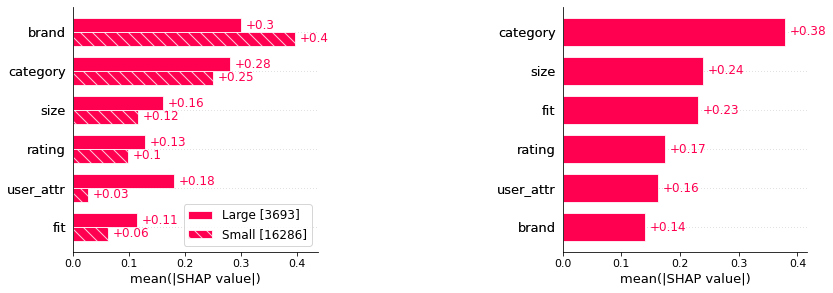

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process


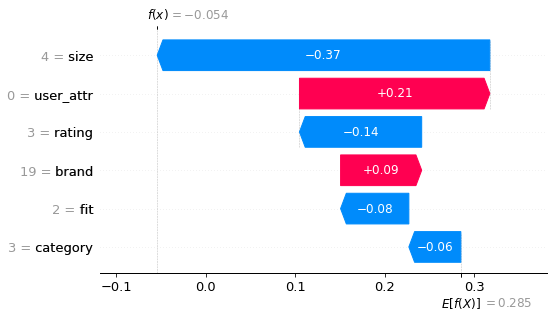

In [19]:
bd.understand_shap(labels,sensitive,0,0)

Affected Group = 0 = Large
Affected Target = 0 = Small


Brand is the most significant variable for both user identity types, large and small, however is relatively more important for small size users than large size users.

Fit is twice as relevant for users dentified with large sizes compared to people identified with small sizes.

For the affected group and target, most relevant variable is category, followed by size and fit, which is significantly more relevant for this group than for the entire population


<a id='3'></a>
## 2. AEQUITAS FRAMEWORK

We are now ready to utilize AEQUITAS to detect bias. 

The Aequitas toolkit is a flexible bias-audit utility for algorithmic decision-making models, accessible via Python API. It will help us out evaluate Modcloth performance across several bias and fairness metrics. Here are the steps involved:

- Understand where biases exist in Modcloth

- Compare the level of bias between groups in our sample population (bias disparity)

- Visualize absolute bias metrics and their related disparities for rapid comprehension and decision-making



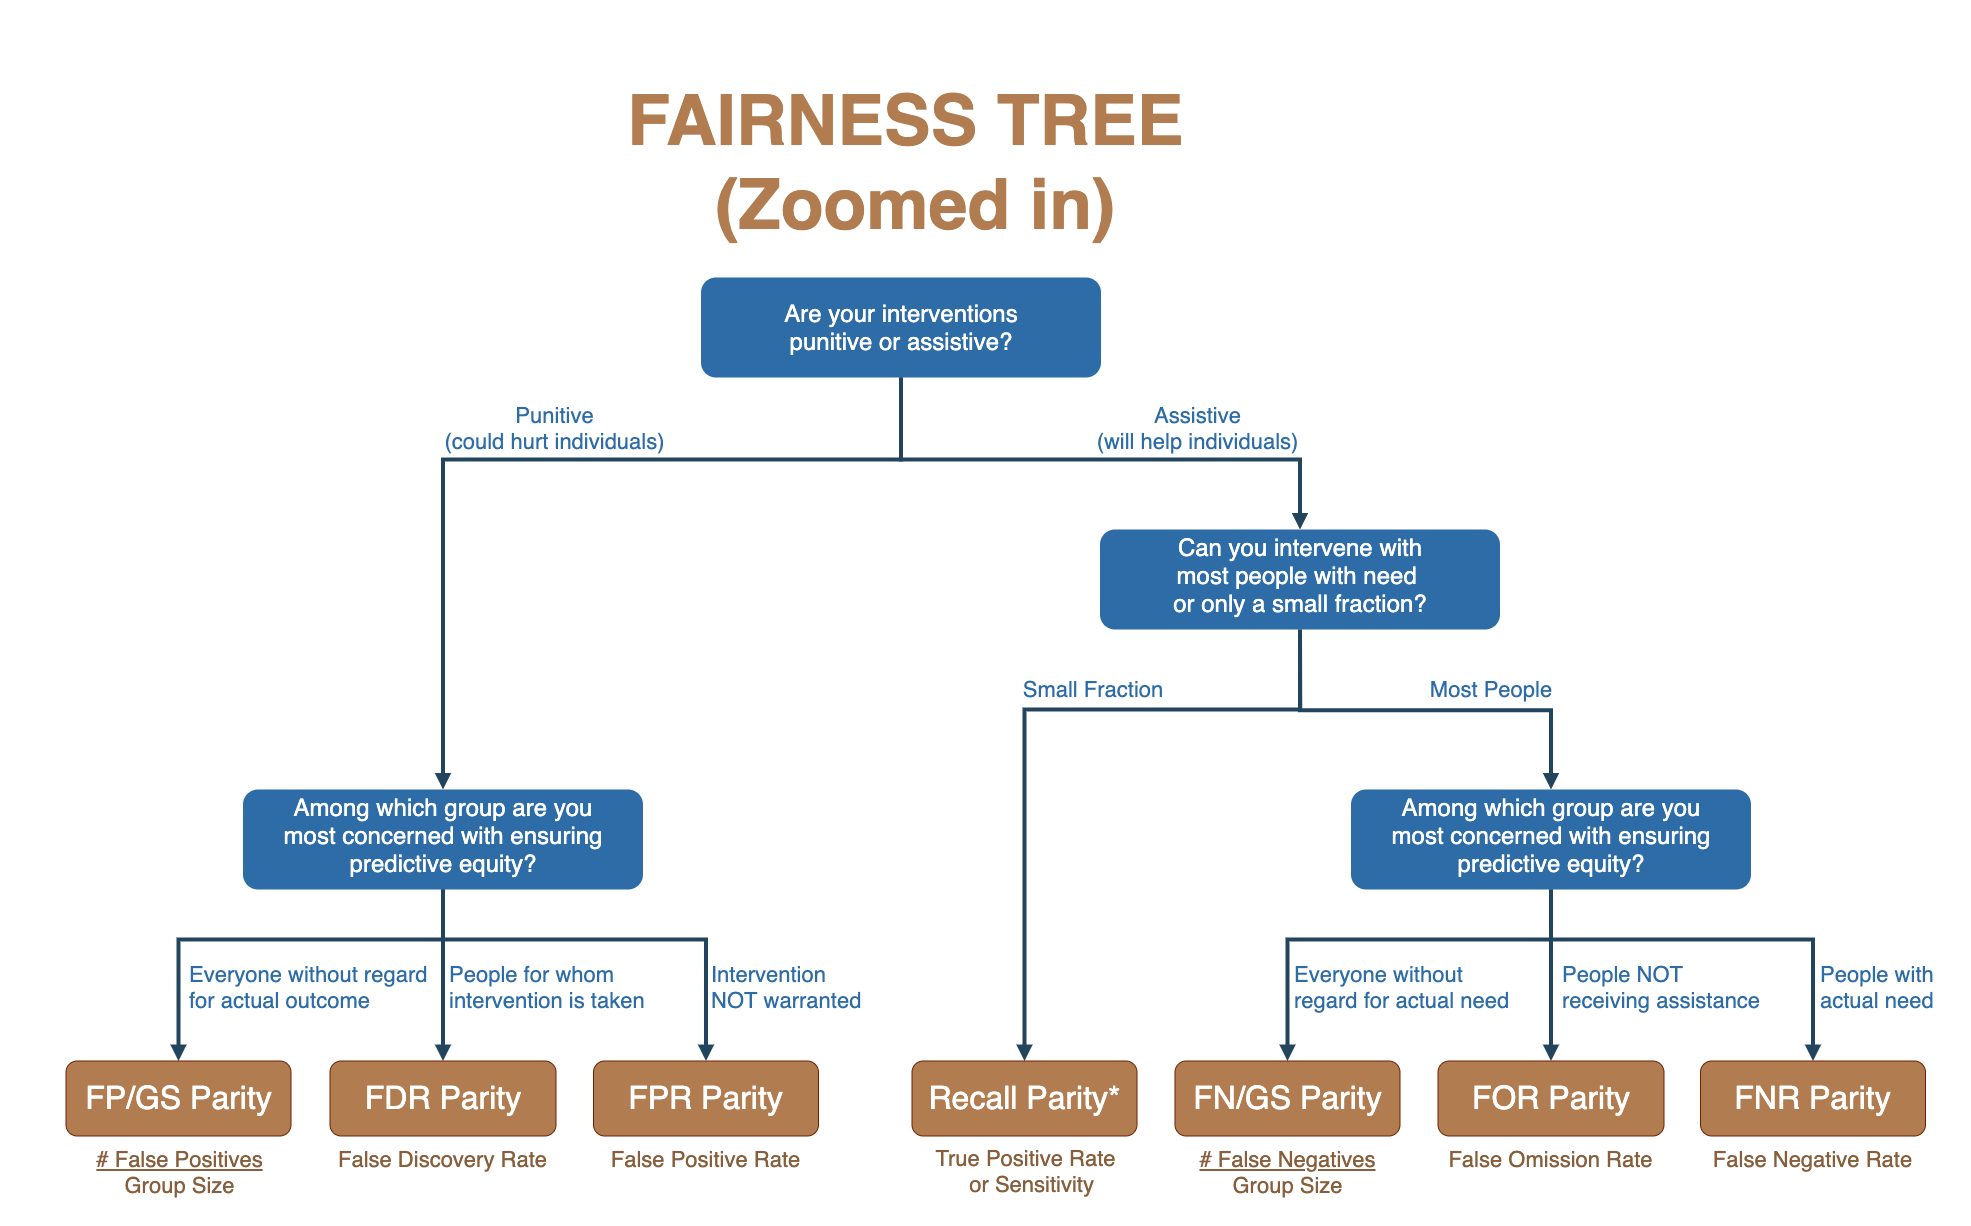

### Import Statements

As with any Python program, the first step will be to import the necessary packages. Below we import several components from the Aequitas package. We also import some other non-Aequitas useful packages.

In [20]:
!pip install aequitas
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Short EDA to Understand Relationships

In the bar charts below, we see a large difference in how these scores for user_attr (User identity: the perception of oneself; we use the same dimension of attribute as in product image. It calculates the average size each user purchased and classify users into ‘Small’ and ‘Large’ groups based on the same standard as the product body shape image) are distributed by fit, with a majority of Just Right, Slighly Small and Slighly Large people identified as user with a small size. 


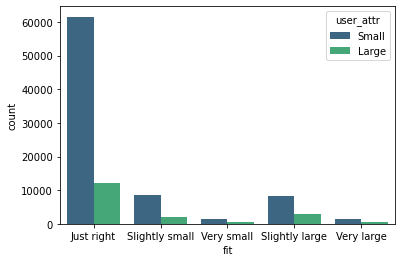

In [21]:
by_fit = sns.countplot(x="fit", hue="user_attr", data=data_ae, palette="viridis")

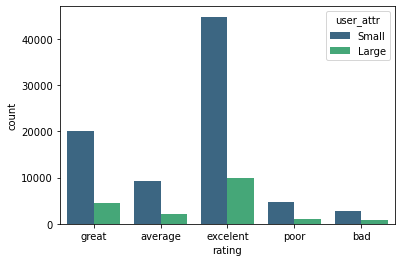

In [22]:
by_rating = sns.countplot(x="rating", hue="user_attr", data=data_ae, palette="viridis")

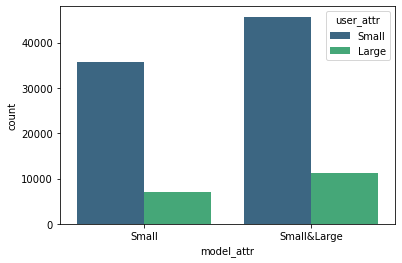

In [23]:
by_model_attr = sns.countplot(x="model_attr", hue="user_attr", data=data_ae, palette="viridis")

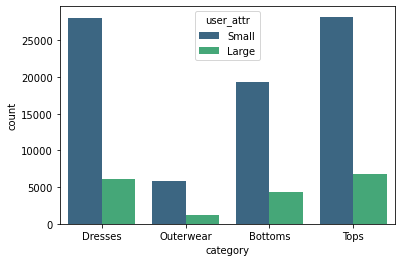

In [24]:
label_by_race = sns.countplot(x="category", hue="user_attr", data=data_ae, palette="viridis")

### Load dataset, specifying protected attribute, and split dataset into train and test

Now that we've identified the protected attribute 'user_attr' and defined privileged and unprivileged values, we can use AEQUITAS to detect bias in the dataset

In [25]:
from sklearn.model_selection import train_test_split

df_ae = data_ae.copy()
X_ae = df_ae.drop(["model_attr"],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y_ae = data_bd['model_attr']

X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(X_ae,y_ae,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")


Data sucessfully loaded!


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

pipe = make_pipeline(OneHotEncoder(handle_unknown="ignore"),
DecisionTreeClassifier(min_samples_leaf=10))
pipe.fit(X_train_ae, y_train_ae)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_leaf=10))])

In [27]:
data_ae_full = X_test_ae.copy().reset_index(drop=True)
data_ae_full["score"] = pipe.predict_proba(X_test_ae)[:, 1]
data_ae_full["label_value"] = y_test_ae.copy().reset_index(drop=True)
data_ae_full.head(n=4)

rating  size             fit user_attr category     brand     score  \
0   average   4.0  Slightly small     Small  Dresses  ModCloth  0.625000   
1  excelent   2.0      Just right     Small  Bottoms  ModCloth  0.495407   
2  excelent   7.0      Just right     Large  Dresses  ModCloth  0.691964   
3  excelent   5.0      Just right     Small  Bottoms  ModCloth  0.391960   

   label_value  
0            0  
1            0  
2            0  
3            1

In [28]:
data_ae_small = data_ae_full[["fit", "user_attr", "category", "rating","score", "label_value"]].copy()
data_ae_small.head(n=5)


fit user_attr category    rating     score  label_value
0  Slightly small     Small  Dresses   average  0.625000            0
1      Just right     Small  Bottoms  excelent  0.495407            0
2      Just right     Large  Dresses  excelent  0.691964            0
3      Just right     Small  Bottoms  excelent  0.391960            1
4      Just right     Small  Dresses  excelent  0.680506            0

### What biases exist in my model?

What is the distribution of groups, predicted scores, and labels across my dataset?

Aequitas’s Group() class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population.

In [29]:
from aequitas.group import Group
g = Group()
xtab, _ = g.get_crosstabs(data_ae_small)

In [30]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [31]:
# View calculated counts across sample population groups
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

model_id score_threshold    k attribute_name attribute_value   pp     pn  \
0          0      binary 0/1  232            fit      Just right  111  14543   
1          0      binary 0/1  232            fit  Slightly large   19   2185   
2          0      binary 0/1  232            fit  Slightly small   70   2210   
3          0      binary 0/1  232            fit      Very large   10    430   
4          0      binary 0/1  232            fit      Very small   22    379   
5          0      binary 0/1  232      user_attr           Large   42   3651   
6          0      binary 0/1  232      user_attr           Small  190  16096   
7          0      binary 0/1  232       category         Bottoms   80   4633   
8          0      binary 0/1  232       category         Dresses   94   6706   
9          0      binary 0/1  232       category       Outerwear   46   1434   
10         0      binary 0/1  232       category            Tops   12   6974   
11         0      binary 0/1  232         rating         average   44   2235   
12         0      binary 0/1  232         rating             bad   15    742   
13         0      binary 0/1  232         rating        excelent  106  10745   
14         0      binary 0/1  232         rating           great   42   4891   
15         0      binary 0/1  232         rating            poor   25   1134   

    fp    fn    tn   tp  group_label_pos  group_label_neg  group_size  \
0    1  8321  6222  110             8431             6223       14654   
1    0  1288   897   19             1307              897        2204   
2    5  1231   979   65             1296              984        2280   
3    1   259   171    9              268              172         440   
4    0   159   220   22              181              220         401   
5    2  2247  1404   40             2287             1406        3693   
6    5  9011  7085  185             9196             7090       16286   
7    0  2278  2355   80             2358             2355        4713   
8    6  3901  2805   88             3989             2811        6800   
9    0   830   604   46              876              604        1480   
10   1  4249  2725   11             4260             2726        6986   
11   3  1229  1006   41             1270             1009        2279   
12   0   380   362   15              395              362         757   
13   1  6283  4462  105             6388             4463       10851   
14   1  2755  2136   41             2796             2137        4933   
15   2   611   523   23              634              525        1159   

    total_entities  
0            19979  
1            19979  
2            19979  
3            19979  
4            19979  
5            19979  
6            19979  
7            19979  
8            19979  
9            19979  
10           19979  
11           19979  
12           19979  
13           19979  
14           19979  
15           19979

In [32]:
#View calculated absolute metrics for each sample population group
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0             fit      Just right  0.01  1.00  0.57  0.01  0.00  0.99  0.43   
1             fit  Slightly large  0.01  1.00  0.59  0.00  0.00  0.99  0.41   
2             fit  Slightly small  0.05  0.99  0.56  0.07  0.01  0.95  0.44   
3             fit      Very large  0.03  0.99  0.60  0.10  0.01  0.97  0.40   
4             fit      Very small  0.12  1.00  0.42  0.00  0.00  0.88  0.58   
5       user_attr           Large  0.02  1.00  0.62  0.05  0.00  0.98  0.38   
6       user_attr           Small  0.02  1.00  0.56  0.03  0.00  0.98  0.44   
7        category         Bottoms  0.03  1.00  0.49  0.00  0.00  0.97  0.51   
8        category         Dresses  0.02  1.00  0.58  0.06  0.00  0.98  0.42   
9        category       Outerwear  0.05  1.00  0.58  0.00  0.00  0.95  0.42   
10       category            Tops  0.00  1.00  0.61  0.08  0.00  1.00  0.39   
11         rating         average  0.03  1.00  0.55  0.07  0.00  0.97  0.45   
12         rating             bad  0.04  1.00  0.51  0.00  0.00  0.96  0.49   
13         rating        excelent  0.02  1.00  0.58  0.01  0.00  0.98  0.42   
14         rating           great  0.01  1.00  0.56  0.02  0.00  0.99  0.44   
15         rating            poor  0.04  1.00  0.54  0.08  0.00  0.96  0.46   

    precision   ppr  pprev  prev  
0        0.99  0.48   0.01  0.58  
1        1.00  0.08   0.01  0.59  
2        0.93  0.30   0.03  0.57  
3        0.90  0.04   0.02  0.61  
4        1.00  0.09   0.05  0.45  
5        0.95  0.18   0.01  0.62  
6        0.97  0.82   0.01  0.56  
7        1.00  0.34   0.02  0.50  
8        0.94  0.41   0.01  0.59  
9        1.00  0.20   0.03  0.59  
10       0.92  0.05   0.00  0.61  
11       0.93  0.19   0.02  0.56  
12       1.00  0.06   0.02  0.52  
13       0.99  0.46   0.01  0.59  
14       0.98  0.18   0.01  0.57  
15       0.92  0.11   0.02  0.55

### Visualizing a single absolute group metric across all population groups

The chart below displays group metric predictive positive rate (ppr) calculated across each attribute, colored based on number of samples in the attribute group.

We can see from the longer bars that across ‘rating’, ‘user_attribute’, and ‘fit’ attributes, the groups Modcloth incorrectly predicts as small & large image profile most often are rated excellent,with ajust right judgement in fit and identified as small size. From the darker coloring, we can also tell that these are the three largest populations in the data set

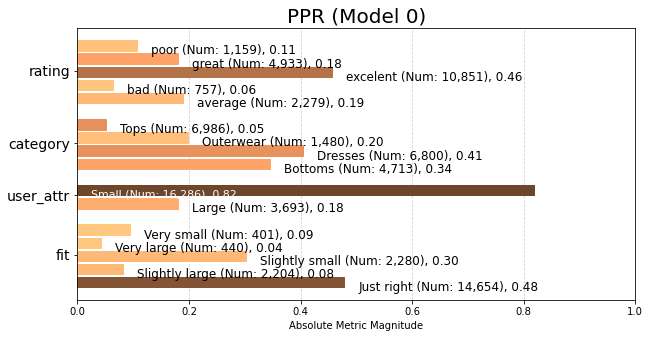

In [33]:
from aequitas.plotting import Plot
aqp = Plot()
ppr = aqp.plot_group_metric(xtab, 'ppr')

### View group metrics for only groups over a certain size threshold

Extremely small group sizes increase standard error of estimates, and could be factors in prediction error such as false negatives, hence we are using the min_group parameter to vizualize only those sample population groups above a user-specified percentage of the total sample size.

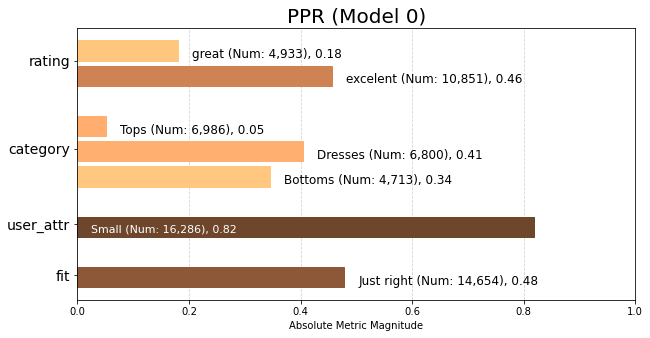

In [34]:

PPR1 = aqp.plot_group_metric(xtab, 'ppr', min_group_size=0.05)

### What levels of disparity exist between population groups?

We use the Aequitas Bias() class to calculate disparities between groups based on the crosstab returned by the Group() class ``get_crosstabs()`` method described above. 

Disparities are calculated as a ratio of a metric for a group of interest compared to a base group.

In [35]:
from aequitas.bias import Bias
    
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, 
            original_df=data_ae_small, 
            ref_groups_dict={'category':'Dresses','user_attr':'Small', 'fit':'Just right', 'rating':'excelent'},
            alpha=0.05, 
            check_significance=False)

get_disparity_predefined_group()


The treemap below displays precision disparity values calculated using a predefined group, in this case the ‘Small’ group within the user_attr attribute, sized based on the group size and colored based on disparity magnitude. The farther from 1 the more disparity exist among the groups

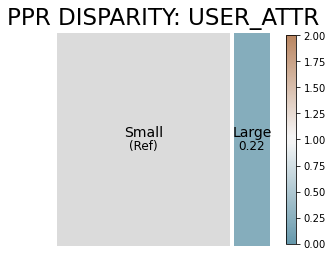

In [36]:
ppr_disparity = aqp.plot_disparity(bdf, group_metric='ppr_disparity',
attribute_name='user_attr')

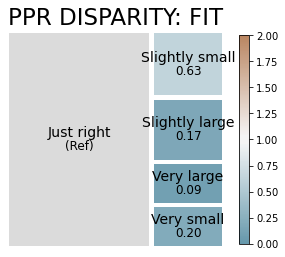

In [37]:
ppr_disparity = aqp.plot_disparity(bdf, group_metric='ppr_disparity',
attribute_name='fit')

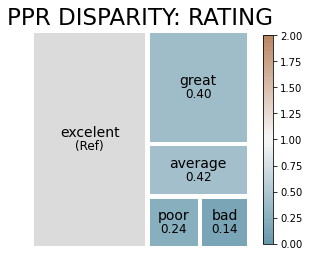

In [38]:
ppr_disparity = aqp.plot_disparity(bdf, group_metric='ppr_disparity',
attribute_name='rating')

### Visualizing parity of a single absolute group metric across all population groups

In [39]:
from aequitas.fairness import Fairness
    
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The chart below displays absolute group metric Predicted Positive Rate Disparity (ppr) across each attribute, colored based on fairness determination for that attribute group (green = ‘True’ and red = ‘False’).

We can see from the green color that only the excelent rating, small user attribute category, and just right fit groups have been determined to be fair. These are the groups selected as reference groups, so this model is not fair in terms of Statistical Parity for any of the other groups.

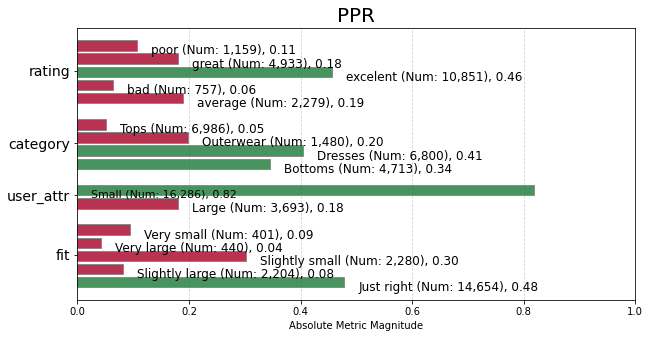

In [40]:
ppr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

### The Parity Test

In [41]:
metrics = ['for', 'fnr', 'npv', 'precision', 'ppr']
disparity_tolerance = 1.5

In [ ]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

In [ ]:
ap.disparity(bdf, metrics, 'fit', fairness_threshold = disparity_tolerance)

In [ ]:
ap.disparity(bdf, metrics, 'user_attr', fairness_threshold = disparity_tolerance)

In [ ]:
ap.disparity(bdf, metrics, 'rating', fairness_threshold = disparity_tolerance)

#https://colab.research.google.com/github/dssg/aequitas/blob/update_compas_notebook/docs/source/examples/compas_demo.ipynb#scrollTo=VjZf_yQC9YtG